In [6]:
# !git clone https://github.com/leekunhee/Mask_RCNN.git
# %cd Mask_RCNN

[Errno 2] No such file or directory: 'Mask_RCNN'
/home/beata/Studia/TP/mask_rcnn_to_tflite/Mask_RCNN


First do small changes to the model

In [3]:
# %cd mrcnn/
# !wget -q -O - "https://gist.githubusercontent.com/wathek/256e8a53263b418fe40c0f3f0127c8e6/raw/64f91cdb5b4ae1b82b4725f5f48a4c16830c6fa2/model.patch" | patch -u model.py -i -

[Errno 2] No such file or directory: 'mrcnn/'
/home/beata/Studia/TP/mask_rcnn_to_tflite/Mask_RCNN/mrcnn


# Mask R-CNN Demo and TFLite Conversion

A quick intro to using the pre-trained model to detect and segment objects.

In [1]:
# %cd /content/Mask_RCNN/
%cd Mask_RCNN

/home/beata/Studia/TP/mask_rcnn_to_tflite/Mask_RCNN


In [2]:
# !pip install git+https://github.com/waleedka/cocoapi.git#egg=pycocotools&subdirectory=PythonAPI

In [3]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("./")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))  # To find local version
import coco
    
%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "images")

In [4]:
class InferenceConfig(coco.CocoConfig):
#     Set batch size to 1 since we'll be running inference on
#     one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()

import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"  



Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

## Create Model and Load Trained Weights

In [5]:
# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# Load weights trained on MS-COCO
model.load_weights(COCO_MODEL_PATH, by_name=True)

Instructions for updating:
Use fn_output_signature instead


In [6]:
# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

## Run Object Detection

Processing 1 images
image                    shape: (640, 425, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  148.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


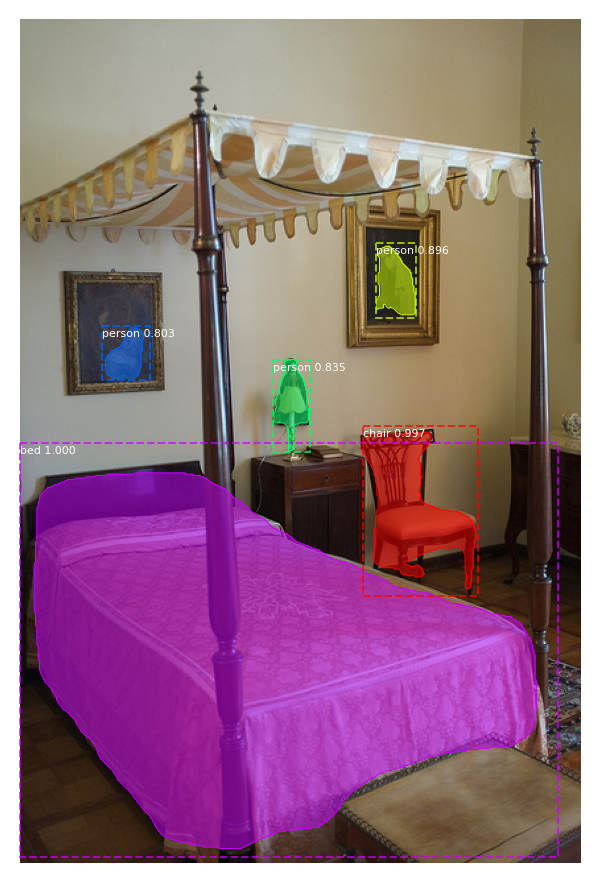

In [7]:
# Load a random image from the images folder
file_names = next(os.walk(IMAGE_DIR))[2]
image = skimage.io.imread(os.path.join(IMAGE_DIR, random.choice(file_names)))

# Run detection
results = model.detect([image], verbose=1)

# Visualize results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])

# Convert Model to TFLite

In [8]:
import tensorflow as tf

In [9]:
print(tf.__version__)

2.3.0


In [10]:
keras_model = model.keras_model
converter = tf.lite.TFLiteConverter.from_keras_model(keras_model)
converter.allow_custom_ops = True
converter.experimental_new_converter = True
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS, # enable TensorFlow Lite ops.
    tf.lite.OpsSet.SELECT_TF_OPS # enable TensorFlow ops.
]

In [11]:
keras_model = model.keras_model
converter = tf.lite.TFLiteConverter.from_keras_model(keras_model)
converter.allow_custom_ops = True
converter.experimental_new_converter = True
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS, # enable TensorFlow Lite ops.
    tf.lite.OpsSet.SELECT_TF_OPS # enable TensorFlow ops.
]

converter.optimizations = [ tf.lite.Optimize.DEFAULT ]

tflite_model = converter.convert()

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /tmp/tmp5dhq1eye/assets


In [12]:
open("model.tflite", "wb").write(tflite_model)

65105360

In [13]:
!ls

assets	LICENSE      mask_rcnn_coco.h5	README.md	  setup.cfg
coco	logs	     model.tflite	requirements.txt  setup.py
images	MANIFEST.in  mrcnn		samples		  venv
